# Atom Position Analysis

## Atom position analysis after a ToF with NO Imaging 

In [1]:
import os
import importlib


working_directory = "D:/PhD_Trieste/Simulations/Imaging_Simulation"

if os.getcwd()!= working_directory:
    os.chdir(working_directory)  
    
print(working_directory)

import Simulations_Libraries.trajectory_library as trajlib
import numpy as np
import matplotlib.pyplot as plt
from Camera import *
from scipy.stats import poisson
from scipy.optimize import curve_fit
import Simulations_Libraries.general_library as genlib
import ArQuS_analysis_lib as anslib
import matplotlib.cm as cm
from tqdm import tqdm


%matplotlib

plt.ion()

D:/PhD_Trieste/Simulations/Imaging_Simulation
Using matplotlib backend: module://matplotlib_inline.backend_inline


D:\Anaconda\envs\Imaging_Simulation\Lib\site-packages\numba\core\decorators.py:248: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
'''------------------------------Parameters-------------------------------------'''
trapType = 'Tweezer'
trapFreq_r = 2*np.pi*140e3
isotope = 171 
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
trapDuration = 0e-6
freeFlightTime = 50e-6
acquisitionDuration = 0e-6
experimentDuration = trapDuration + freeFlightTime
imagingOption = 'FS'
nOfAtoms = 1

initialT = np.array([10,20,30,40,50,60,70,80,90,100])*1e-6
selectedT = np.array([10,50,100])*1e-6


Loading Data:   0%|                                                                             | 0/10 [00:00<?, ?it/s]

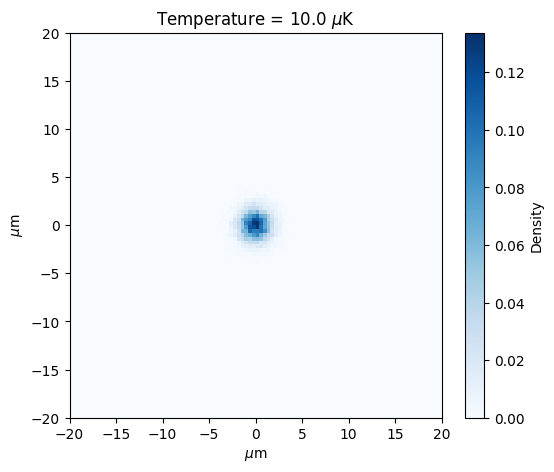

Loading Data:  40%|███████████████████████████▌                                         | 4/10 [03:14<04:52, 48.76s/it]

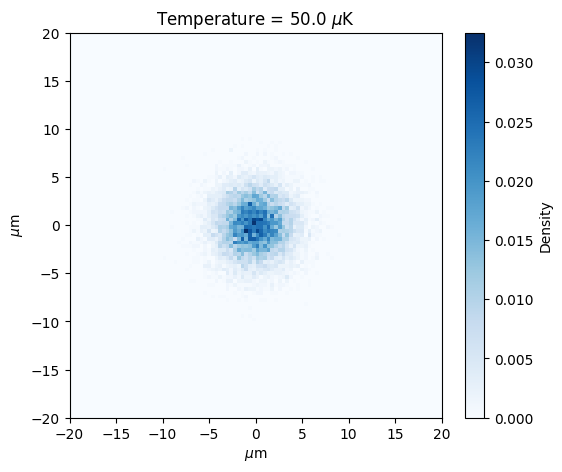

Loading Data:  90%|██████████████████████████████████████████████████████████████       | 9/10 [07:22<00:48, 48.98s/it]

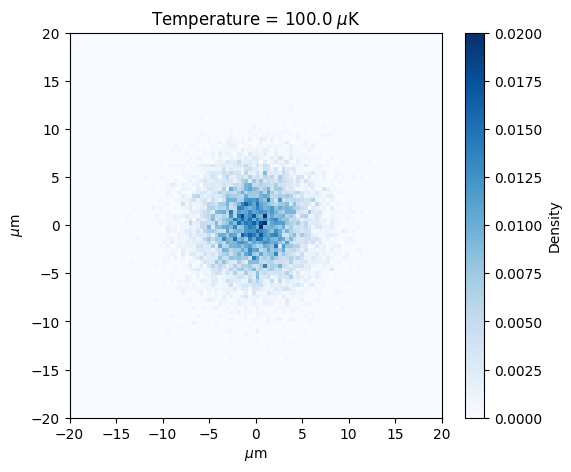

Loading Data: 100%|████████████████████████████████████████████████████████████████████| 10/10 [08:12<00:00, 49.28s/it]


In [3]:
positionXRMS = []
positionYRMS = []
measuredT = []

for j in tqdm(range(len(initialT)), desc="Loading Data",mininterval=1,maxinterval=30):
    
    '''-------------------------------folders and files------------------------------'''
    extraWord = f'_Temperature_{np.round(initialT[j]*1e6)}uK'
    pictureFolder = working_directory +  f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord
    simulationFolder = working_directory + f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord + "/simulation/"
    baseFileName = "simulation"
    blurFolder = "bigBlurs/"       # PSF along the camera axis
    backgroundNoiseFolder = "Orca_testing/shots_free_space/"
    repeat = 0
    stop = False
    
    positionX = []
    positionY = []
    positionZ = []
    
    while not stop:
        fileName = f"{baseFileName}_{repeat}.h5"
        imageFileName = f"{pictureFolder}/{fileName}"
        simulationFileName = f"{simulationFolder}/{fileName}"
        exp = trajlib.experiment() 
        if not os.path.exists(simulationFileName):
            stop = True
        else:
            repeat +=1
            
            metadata = exp.loadAcquisition(simulationFileName)
           
    
            trajectoriesX = exp.lastPositons[:,:,0]
            trajectoriesY = exp.lastPositons[:,:,1]
            trajectoriesZ = exp.lastPositons[:,:,2]
            for i in range(trajectoriesX.shape[1]):
                positionX.append(trajectoriesX[:,i][~np.isnan(trajectoriesX[:,i])][-1])
                positionY.append(trajectoriesY[:,i][~np.isnan(trajectoriesY[:,i])][-1])
                positionZ.append(trajectoriesZ[:,i][~np.isnan(trajectoriesZ[:,i])][-1])
                
    positionX = np.array(positionX)
    positionY = np.array(positionY)
    positionZ = np.array(positionZ)

    x_RMS = np.sqrt(np.mean(positionX**2))
    y_RMS = np.sqrt(np.mean(positionY**2))
    positionXRMS.append(x_RMS)
    positionYRMS.append(y_RMS)
    measuredT.append( ( baseAtom.m * np.mean([x_RMS,y_RMS])**2 ) / trajlib.kB / ( (1/trapFreq_r**2) + freeFlightTime**2 ) )

    if np.any(selectedT==initialT[j]):
        anslib.AtomPositionHistogram(positionsX = positionX, positionsY = positionY, bins = 100, binLimit=20e-6,title = f'Temperature = {np.round(initialT[j]*1e6,2)} $\mu$K')


positionsXRMS = np.asarray(positionXRMS)
positionsYRMS = np.asarray(positionYRMS)
measuredT = np.asarray(measuredT)



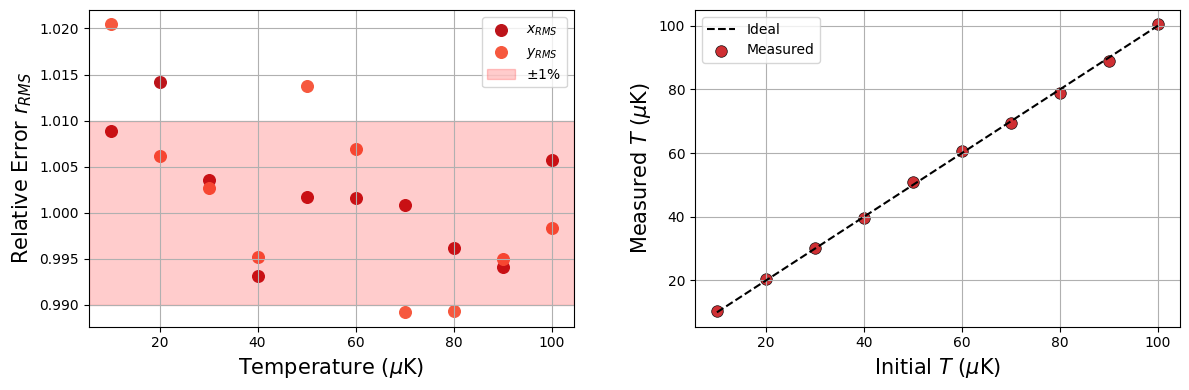

In [4]:

thRMSPosition = np.sqrt(initialT*trajlib.kB/baseAtom.m) * np.sqrt((1/trapFreq_r**2) + (freeFlightTime**2))

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plots
axs[0].scatter(initialT*1e6, positionXRMS/thRMSPosition, color=cm.Reds(0.8),label = '$x_{RMS}$',s = 70)
axs[0].scatter(initialT*1e6, positionYRMS/thRMSPosition, color=cm.Reds(0.55), label = '$y_{RMS}$', s = 70)
axs[0].set_ylabel(r'Relative Error $r_{RMS}$',fontsize = 15)
axs[0].set_xlabel(r'Temperature ($\mu$K)',fontsize = 15)
axs[0].axhspan(0.99, 1.01, color='red', alpha=0.2, label=r'$\pm1 \%$')
axs[0].legend()
axs[0].grid()

axs[1].plot(initialT*1e6, initialT*1e6,ls = '--',color = 'black',label = 'Ideal')
axs[1].scatter(initialT * 1e6,measuredT * 1e6,s=70,color=cm.Reds(0.75),edgecolor="black",linewidth=0.5,alpha=0.9,label = 'Measured')
axs[1].set_ylabel(r'Measured $T$ ($\mu$K)',fontsize = 15)
axs[1].set_xlabel(r'Initial $T$ ($\mu$K)',fontsize = 15)
axs[1].legend()
axs[1].grid()


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

&nbsp;


&nbsp;

&nbsp;


&nbsp;

&nbsp;


&nbsp;

## Atom Position Analysis after a ToF with Imaging from Computed Positions

In [5]:
'''------------------------------Parameters-------------------------------------'''
trapType = 'Tweezer'
trapFreq_r = 2*np.pi*140e3
isotope = 171 
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
trapDuration = 0e-6
freeFlightTime = 50e-6
acquisitionDuration = 7e-6
experimentDuration = trapDuration + freeFlightTime
imagingOption = 'FS'
nOfAtoms = 1

initialT = np.array([10,20,30,40,50,60,70,80,90,100])*1e-6
selectedT = np.array([10,50,100])*1e-6

Loading Data:   0%|                                                                             | 0/10 [00:00<?, ?it/s]

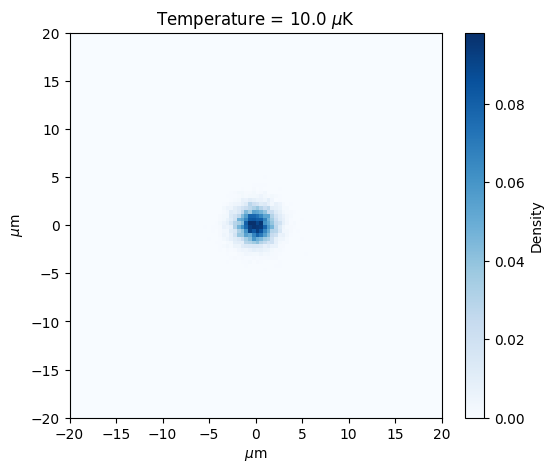

Loading Data:  40%|███████████████████████████▌                                         | 4/10 [04:45<07:08, 71.41s/it]

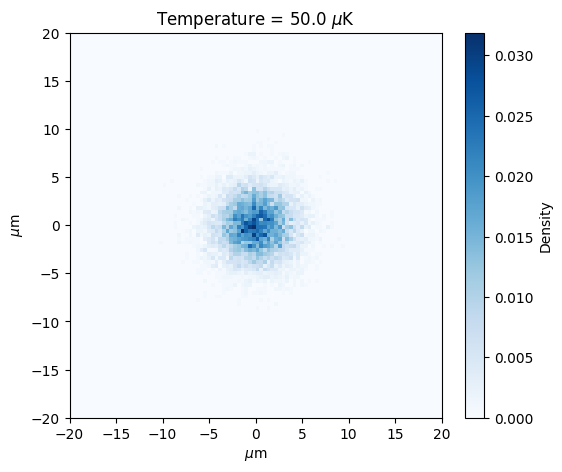

Loading Data:  90%|██████████████████████████████████████████████████████████████       | 9/10 [10:47<01:13, 73.01s/it]

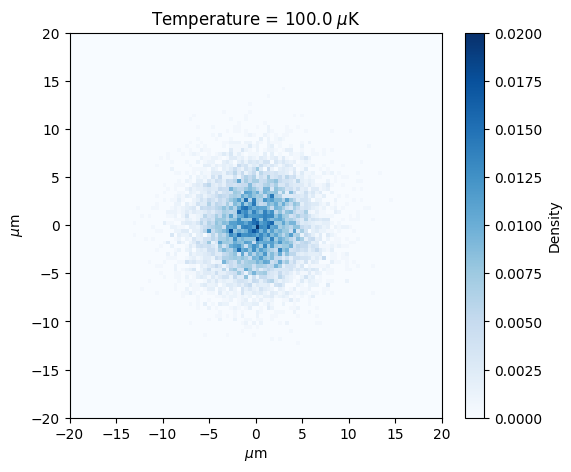

Loading Data: 100%|████████████████████████████████████████████████████████████████████| 10/10 [11:59<00:00, 71.99s/it]


In [6]:
positionImagingXRMS = []
positionImagingYRMS = []
measuredTImaging = []

for j in tqdm(range(len(initialT)), desc="Loading Data",mininterval=1,maxinterval=30):
    
    '''-------------------------------folders and files------------------------------'''
    extraWord = f'_Temperature_{np.round(initialT[j]*1e6)}uK'
    pictureFolder = working_directory +  f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord
    simulationFolder = working_directory + f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord + "/simulation/"
    baseFileName = "simulation"
    blurFolder = "bigBlurs/"       # PSF along the camera axis
    backgroundNoiseFolder = "Orca_testing/shots_free_space/"
    repeat = 0
    stop = False
    
    positionX = []
    positionY = []
    positionZ = []
    
    while not stop:
        fileName = f"{baseFileName}_{repeat}.h5"
        imageFileName = f"{pictureFolder}/{fileName}"
        simulationFileName = f"{simulationFolder}/{fileName}"
        exp = trajlib.experiment() 
        if not os.path.exists(simulationFileName):
            stop = True
        else:
            repeat +=1
            
            metadata = exp.loadAcquisition(simulationFileName)
           
    
            trajectoriesX = exp.lastPositons[:,:,0]
            trajectoriesY = exp.lastPositons[:,:,1]
            trajectoriesZ = exp.lastPositons[:,:,2]
            for i in range(trajectoriesX.shape[1]):
                positionX.append(trajectoriesX[:,i][~np.isnan(trajectoriesX[:,i])][-1])
                positionY.append(trajectoriesY[:,i][~np.isnan(trajectoriesY[:,i])][-1])
                positionZ.append(trajectoriesZ[:,i][~np.isnan(trajectoriesZ[:,i])][-1])
                
    positionX = np.array(positionX)
    positionY = np.array(positionY)
    positionZ = np.array(positionZ)

    x_RMS = np.sqrt(np.mean(positionX**2))
    y_RMS = np.sqrt(np.mean(positionY**2))
    positionImagingXRMS.append(x_RMS)
    positionImagingYRMS.append(y_RMS)
    measuredTImaging.append( ( baseAtom.m * np.mean([x_RMS,y_RMS])**2 ) / trajlib.kB / ( (1/trapFreq_r**2) + freeFlightTime**2 ) )

    if np.any(selectedT==initialT[j]):
        anslib.AtomPositionHistogram(positionsX = positionX, positionsY = positionY, bins = 100, binLimit=20e-6,title = f'Temperature = {np.round(initialT[j]*1e6,2)} $\mu$K')


positionsImagingXRMS = np.asarray(positionImagingXRMS)
positionsImagingYRMS = np.asarray(positionImagingYRMS)
measuredTImaging = np.asarray(measuredTImaging)



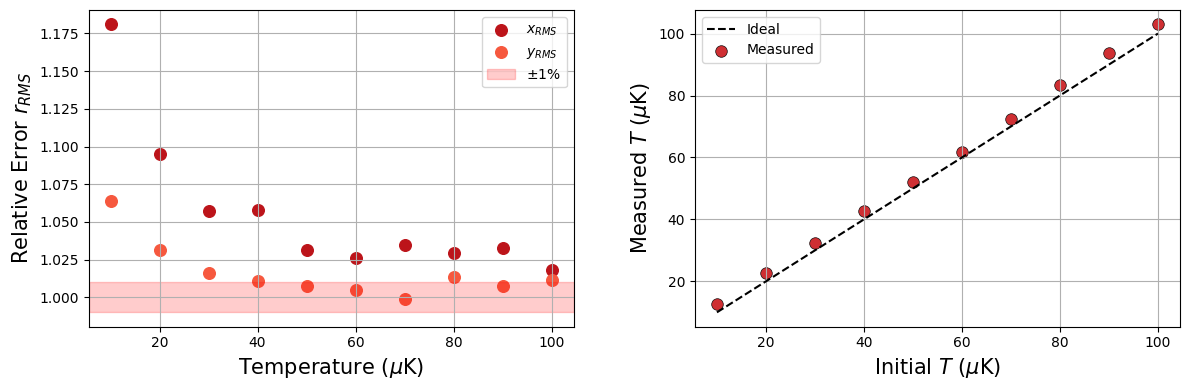

In [7]:

thRMSPosition = np.sqrt(initialT*trajlib.kB/baseAtom.m) * np.sqrt((1/trapFreq_r**2) + (freeFlightTime**2))

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plots
axs[0].scatter(initialT*1e6, positionImagingXRMS/thRMSPosition, color=cm.Reds(0.8),label = '$x_{RMS}$',s = 70)
axs[0].scatter(initialT*1e6, positionImagingYRMS/thRMSPosition, color=cm.Reds(0.55), label = '$y_{RMS}$', s = 70)
axs[0].set_ylabel(r'Relative Error $r_{RMS}$',fontsize = 15)
axs[0].set_xlabel(r'Temperature ($\mu$K)',fontsize = 15)
axs[0].axhspan(0.99, 1.01, color='red', alpha=0.2, label=r'$\pm1 \%$')
axs[0].legend()
axs[0].grid()

axs[1].plot(initialT*1e6, initialT*1e6,ls = '--',color = 'black',label = 'Ideal')
axs[1].scatter(initialT * 1e6,measuredTImaging * 1e6,s=70,color=cm.Reds(0.75),edgecolor="black",linewidth=0.5,alpha=0.9,label = 'Measured')
axs[1].set_ylabel(r'Measured $T$ ($\mu$K)',fontsize = 15)
axs[1].set_xlabel(r'Initial $T$ ($\mu$K)',fontsize = 15)
axs[1].legend()
axs[1].grid()


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

&nbsp;


&nbsp;

&nbsp;


&nbsp;

&nbsp;


&nbsp;

## Atom Position Analysis after a ToF with Imaging from Camera Images

In [8]:
'''------------------------------Parameters-------------------------------------'''
trapType = 'Tweezer'
trapFreq_r = 2*np.pi*140e3
isotope = 171 
baseAtom = trajlib.Ytterbium(0,0,0, 0,0,0,isotope=isotope)
trapDuration = 0e-6
freeFlightTime = 50e-6
acquisitionDuration = 7e-6
experimentDuration = trapDuration + freeFlightTime
imagingOption = 'FS'
nOfAtoms = 1

initialT = np.array([10,20,30,40,50,60,70,80,90,100])*1e-6

In [9]:

meanImages = []


for j in tqdm(range(len(initialT)), desc="Loading Data",mininterval=1,maxinterval=30):
    
    '''-------------------------------folders and files------------------------------'''
    extraWord = f'_Temperature_{np.round(initialT[j]*1e6)}uK'
    pictureFolder = working_directory +  f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord
    simulationFolder = working_directory + f"/simulationImages/{trapType}/Yt{isotope}_{int(experimentDuration*1e6)}us_{trapType}Duration{trapDuration*1e6}us_freeFlight{freeFlightTime*1e6}us_imagingTime{acquisitionDuration*1e6}us_imaging{imagingOption}_{nOfAtoms}" + extraWord + "/simulation/"
    baseFileName = "simulation"
    blurFolder = "bigBlurs/"       # PSF along the camera axis
    backgroundNoiseFolder = "Orca_testing/shots_free_space/"
    repeat = 0
    stop = False

    meanImage = np.zeros([108,108])
    
    while not stop:
        fileName = f"{baseFileName}_{repeat}.h5"
        imageFileName = f"{pictureFolder}/{fileName}"
        simulationFileName = f"{simulationFolder}/{fileName}"
        if not os.path.exists(simulationFileName):
            stop = True
        else:
            repeat +=1

            meanImage[:,:] += load_h5_image(path = imageFileName, internalPath = None, returnMetadata = False)

    meanImages.append(meanImage/repeat) 
           
    
            




Loading Data: 100%|████████████████████████████████████████████████████████████████████| 10/10 [09:21<00:00, 56.19s/it]


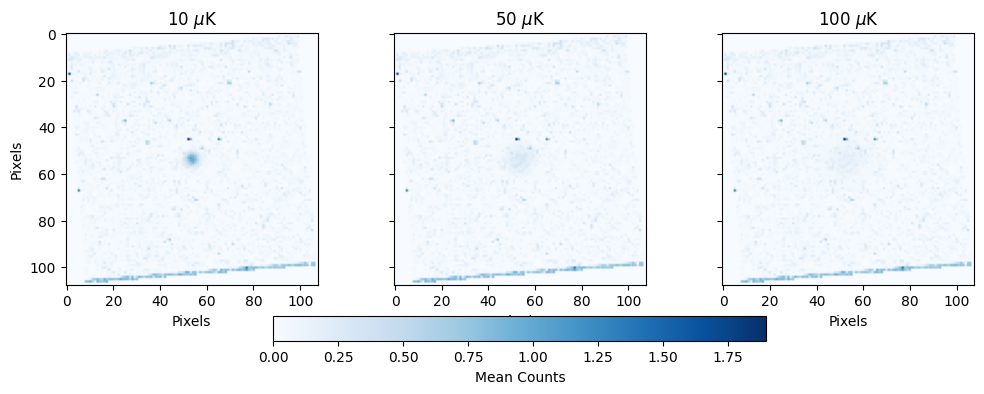

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Determine common color scale
vmin = min(meanImages[0].min(), meanImages[4].min(), meanImages[9].min())
vmax = max(meanImages[0].max(), meanImages[4].max(), meanImages[9].max())

cmap = 'Blues'
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# --- First image ---
im0 = axs[0].imshow(meanImages[0], vmin=vmin, vmax=vmax, cmap = cmap)
axs[0].set_title(r"10 $\mu$K")
axs[0].set_xlabel("Pixels")
axs[0].set_ylabel("Pixels")

# --- Second image ---
im1 = axs[1].imshow(meanImages[4], vmin=vmin, vmax=vmax, cmap = cmap)
axs[1].set_title(r"50 $\mu$K")
axs[1].set_xlabel("Pixels")

# --- Third image ---
im2 = axs[2].imshow(meanImages[9], vmin=vmin, vmax=vmax, cmap = cmap)
axs[2].set_title(r"100 $\mu$K")
axs[2].set_xlabel("Pixels")

# --- Shared colorbar (bottom) ---
cbar = fig.colorbar(
    im2,
    ax=axs,
    orientation="horizontal",
    fraction=0.08,
    pad=0.20,
    cmap = cmap
)
cbar.set_label("Mean Counts")

# 🔑 Reserve space for the colorbar
plt.subplots_adjust(bottom=0.25)

plt.show()



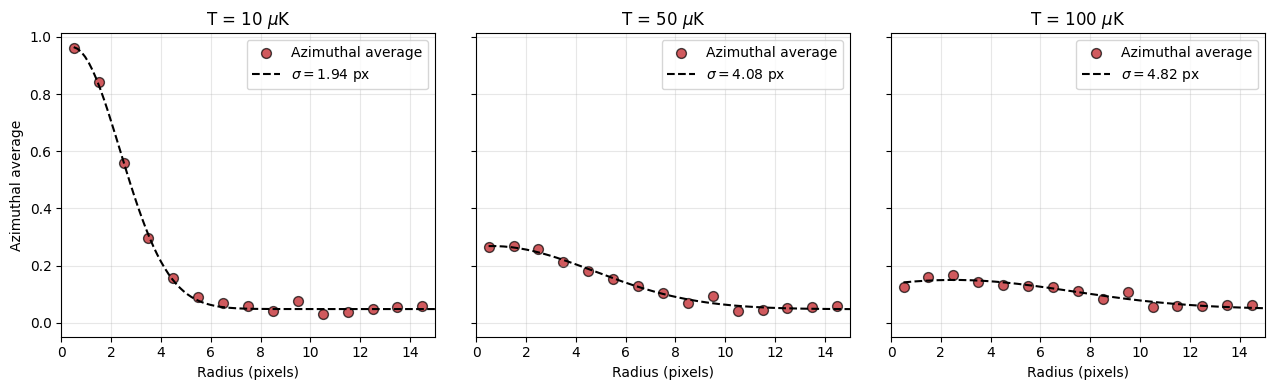

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

indices = np.array([0, 4, 9])
centers = np.ones([2, len(initialT)]) * 54

# --- Azimuthal average function ---
def azimuthal_average(image, center=None, bin_size=1):
    ny, nx = image.shape
    if center is None:
        center = (nx // 2, ny // 2)

    x0, y0 = center
    y, x = np.indices(image.shape)
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    r_bin = (r / bin_size).astype(int)
    radial_sum = np.bincount(r_bin.ravel(), image.ravel())
    radial_count = np.bincount(r_bin.ravel())

    radial_mean = radial_sum / radial_count
    r_values = (np.arange(len(radial_mean)) + 0.5) * bin_size

    return r_values, radial_mean


# --- Gaussian model ---
def gaussian(r, A, r0, sigma, C):
    return A * np.exp(-(r - r0)**2 / (2 * sigma**2)) + C


# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for ax, idx in zip(axes, indices):

    r, profile = azimuthal_average(
        meanImages[int(idx)],
        center=tuple(centers[:, idx])
    )

    # Initial guesses
    A0 = profile.max() - profile.min()
    r0_0 = r[np.argmax(profile)]
    sigma0 = r.max() / 10
    C0 = profile.min()
    p0 = [A0, r0_0, sigma0, C0]

    # Fit
    popt, _ = curve_fit(gaussian, r, profile, p0=p0)
    A, r0, sigma, C = popt

    # Fit curve
    r_fit = np.linspace(r.min(), r.max(), 500)
    profile_fit = gaussian(r_fit, *popt)

    # Plot
    ax.scatter(r, profile, s=50, label="Azimuthal average",color = cm.Reds(0.8),edgecolor = 'black',alpha = 0.7)
    ax.plot(r_fit, profile_fit, '--', label=fr"$\sigma={sigma:.2f}$ px",color = 'black')
    ax.set_xlim(0, 15)
    ax.set_xlabel("Radius (pixels)")
    ax.set_title(f"T = {int((idx+1) * 10)} $\mu$K")
    ax.grid(alpha=0.3)
    ax.legend()

axes[0].set_ylabel("Azimuthal average")

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

sigmaPixels = []
errorSigmaPixels = []
# --- Azimuthal average function (must already exist) ---
def azimuthal_average(image, center=None, bin_size=1):
    ny, nx = image.shape
    if center is None:
        center = (nx // 2, ny // 2)

    x0, y0 = center
    y, x = np.indices(image.shape)
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    r_bin = (r / bin_size).astype(int)
    radial_sum = np.bincount(r_bin.ravel(), image.ravel())
    radial_count = np.bincount(r_bin.ravel())

    radial_mean = radial_sum / radial_count
    r_values = (np.arange(len(radial_mean)) + 0.5) * bin_size

    return r_values, radial_mean


# --- Gaussian model ---
def gaussian(r, A, r0, sigma, C):
    return A * np.exp(-(r - r0)**2 / (2 * sigma**2)) + C


# --- Data ---
for i in range(len(initialT)):
    
    r, profile = azimuthal_average(meanImages[i], center=tuple(centers[:,i]))
    
    # --- Initial guesses ---
    A0 = profile.max() - profile.min()
    r0_0 = r[np.argmax(profile)]
    sigma0 = r.max() / 10
    C0 = profile.min()
    
    p0 = [A0, r0_0, sigma0, C0]
    
    # --- Fit ---
    popt, pcov = curve_fit(gaussian, r, profile, p0=p0)
    
    A, r0, sigma, C = popt
    errorSigma = np.sqrt(pcov[2][2])
    
    sigmaPixels.append(sigma)
    errorSigmaPixels.append(errorSigma)


pixelSize = 4.6e-6
magnification = 8


conversionFactor = pixelSize/magnification
sigmaPixels = np.asarray(sigmaPixels)
errorSigmaPixels = np.asarray(errorSigmaPixels)
sigmaUM = sigmaPixels * conversionFactor
errorSigmaUM = errorSigmaPixels * conversionFactor 
measuredTCameraPictures =  ( baseAtom.m *sigmaUM**2 ) / trajlib.kB / ( (1/trapFreq_r**2) + freeFlightTime**2 ) 
errorMeasuredTCameraPictures = 2 * ( baseAtom.m ) / trajlib.kB / ( (1/trapFreq_r**2) + freeFlightTime**2 ) * sigmaUM*errorSigmaUM



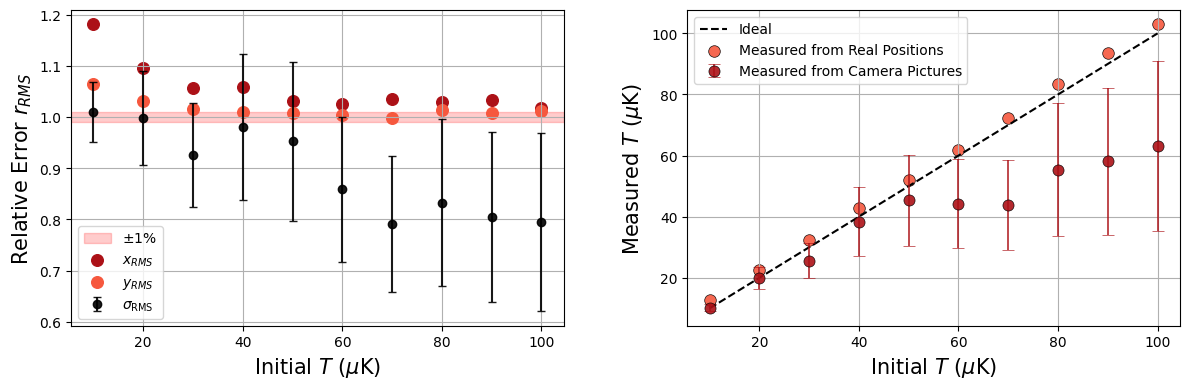

In [16]:

thRMSPosition = np.sqrt(initialT*trajlib.kB/baseAtom.m) * np.sqrt((1/trapFreq_r**2) + (freeFlightTime**2))

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plots
axs[0].axhspan(0.99, 1.01, color='red', alpha=0.2, label=r'$\pm1 \%$')
axs[0].errorbar(
    initialT * 1e6,
    sigmaUM / thRMSPosition,
    yerr=errorSigmaUM / thRMSPosition,
    fmt='o',
    color='black',
    alpha=0.9,
    capsize=3,
    label=r'$\sigma_{\mathrm{RMS}}$'
)
axs[0].scatter(initialT*1e6, positionImagingXRMS/thRMSPosition, color=cm.Reds(0.85), label = '$x_{RMS}$', s = 70)
axs[0].scatter(initialT*1e6, positionImagingYRMS/thRMSPosition, color=cm.Reds(0.55), label = '$y_{RMS}$', s = 70)
axs[0].set_ylabel(r'Relative Error $r_{RMS}$',fontsize = 15)
axs[0].set_xlabel(r'Initial $T$ ($\mu$K)',fontsize = 15)

axs[0].legend()
axs[0].grid()

axs[1].plot(initialT*1e6, initialT*1e6,ls = '--',color = 'black',label = 'Ideal')
axs[1].scatter(initialT * 1e6,measuredTImaging * 1e6,s=70,color=cm.Reds(0.55),edgecolor="black",linewidth=0.5,alpha=0.9,label = 'Measured from Real Positions')

axs[1].errorbar(
    initialT * 1e6,
    measuredTCameraPictures * 1e6,
    yerr=errorMeasuredTCameraPictures * 1e6,
    fmt='o',
    markersize=8,
    color=cm.Reds(0.85),
    markeredgecolor="black",
    markeredgewidth=0.5,
    elinewidth=1.2,
    capsize=4,
    alpha=0.9,
    label="Measured from Camera Pictures"
)
axs[1].set_ylabel(r'Measured $T$ ($\mu$K)',fontsize = 15)
axs[1].set_xlabel(r'Initial $T$ ($\mu$K)',fontsize = 15)
axs[1].legend()
axs[1].grid()


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()